<a href="https://colab.research.google.com/github/YSY4606/test_poject/blob/main/6%EC%A3%BC%EC%B0%A8_%EC%8B%A4%EC%8A%B5%EA%B3%BC%EC%A0%9C_LSTM%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EA%B8%B0%EC%95%84_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15, 20)

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**설치

In [2]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import FinanceDataReader as fdr

In [4]:
kia = fdr.DataReader('000270')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [5]:
kia.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-07-05,78700,79200,76600,78400,1012601,-0.001274
2022-07-06,77700,78000,75400,75400,1447986,-0.038265
2022-07-07,75900,76400,74600,75700,1440566,0.003979
2022-07-08,76600,77800,76100,76800,1079764,0.014531
2022-07-11,78300,79700,77900,78000,1248308,0.015625


In [8]:
STOCK_CODE = '000270'

In [9]:
stock = fdr.DataReader(STOCK_CODE)

In [10]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-05-07,31000,31000,29092,30141,76200,NaN
1998-05-08,30142,30142,29092,29092,75550,-0.034803
1998-05-09,30523,30523,30523,30523,86620,0.049189
1998-05-11,30523,30523,29474,30523,73380,0.000000
1998-05-12,30523,30523,29665,30523,106590,0.000000


In [11]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-07-05,78700,79200,76600,78400,1012601,-0.001274
2022-07-06,77700,78000,75400,75400,1447986,-0.038265
2022-07-07,75900,76400,74600,75700,1440566,0.003979
2022-07-08,76600,77800,76100,76800,1079764,0.014531
2022-07-11,78300,79700,77900,78000,1248308,0.015625


In [12]:
stock.index

DatetimeIndex(['1998-05-07', '1998-05-08', '1998-05-09', '1998-05-11',
               '1998-05-12', '1998-05-13', '1998-05-14', '1998-05-15',
               '1998-05-16', '1998-05-18',
               ...
               '2022-06-28', '2022-06-29', '2022-06-30', '2022-07-01',
               '2022-07-04', '2022-07-05', '2022-07-06', '2022-07-07',
               '2022-07-08', '2022-07-11'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [13]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [14]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1998-05-07,31000,31000,29092,30141,76200,NaN,1998,5,7
1998-05-08,30142,30142,29092,29092,75550,-0.034803,1998,5,8
1998-05-09,30523,30523,30523,30523,86620,0.049189,1998,5,9
1998-05-11,30523,30523,29474,30523,73380,0.000000,1998,5,11
1998-05-12,30523,30523,29665,30523,106590,0.000000,1998,5,12


## 시각화

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


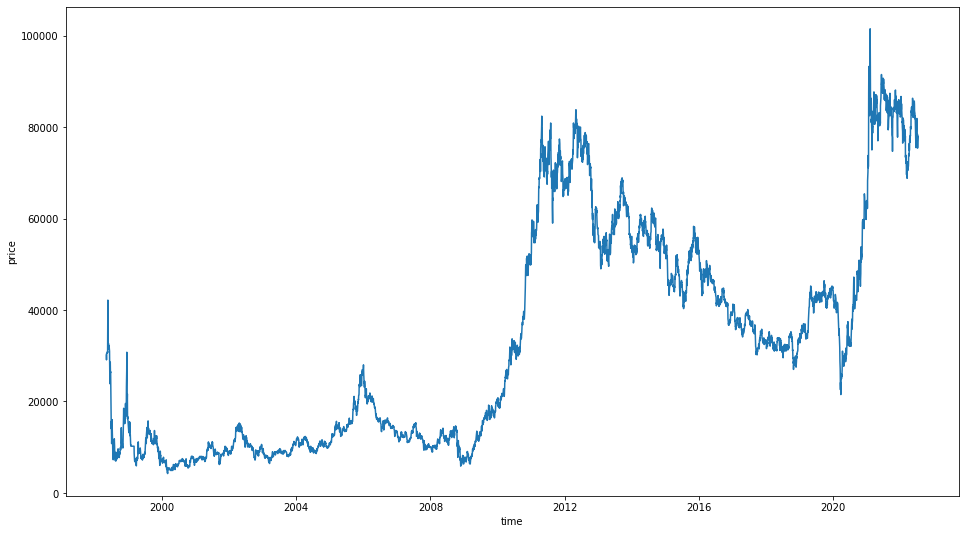

In [15]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


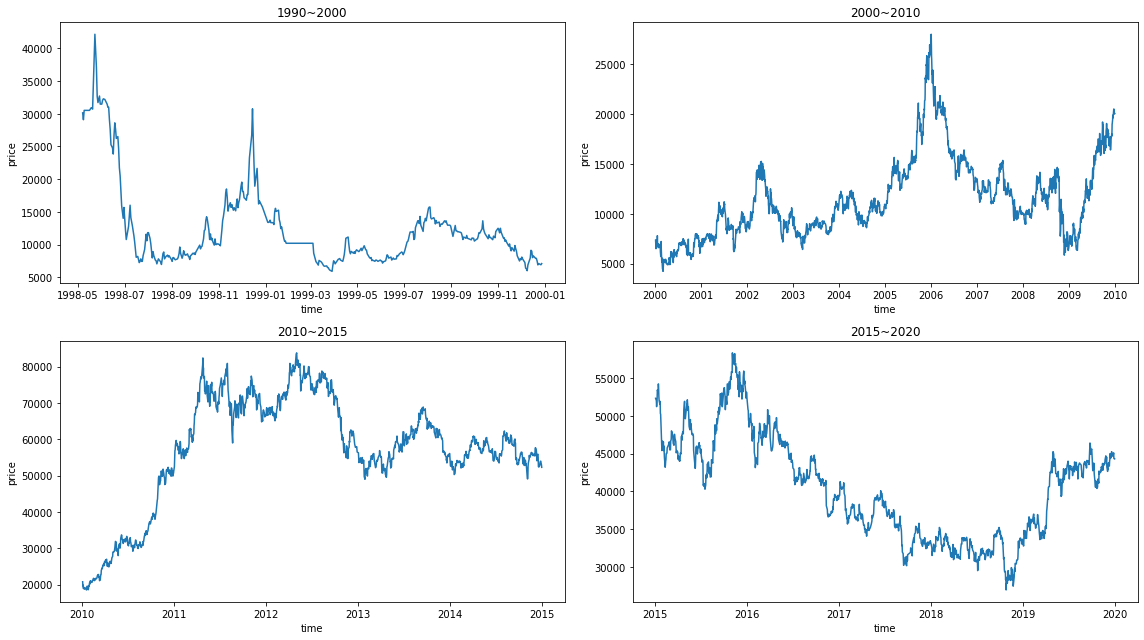

In [16]:
time_steps = [['1990', '2000'], # 특정기간을 설정하여 subplot 표현
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax) # 선형플롯
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # MinMaxScaler 인스턴스화

# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.27810958, 0.27115947, 0.27090475, 0.26641994, 0.00151937],
       [0.26919761, 0.26235179, 0.27090475, 0.25563608, 0.00150641],
       [0.27315502, 0.2662629 , 0.28642873, 0.27034695, 0.00172713],
       ...,
       [0.74448195, 0.7372068 , 0.76459102, 0.73477255, 0.02872371],
       [0.75175279, 0.7515783 , 0.78086353, 0.7460807 , 0.02152961],
       [0.76941054, 0.77108248, 0.80039054, 0.75841686, 0.02489024]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [18]:
df = pd.DataFrame(scaled, columns=scale_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6000 non-null   float64
 1   High    6000 non-null   float64
 2   Low     6000 non-null   float64
 3   Close   6000 non-null   float64
 4   Volume  6000 non-null   float64
dtypes: float64(5)
memory usage: 234.5 KB


## train / test 분할

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [21]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [22]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [23]:
x_train

,Open,High,Low,Volume
0,0.278110,0.271159,0.270905,0.001519
1,0.269198,0.262352,0.270905,0.001506
2,0.273155,0.266263,0.286429,0.001727
3,0.273155,0.266263,0.275049,0.001463
4,0.273155,0.266263,0.277121,0.002125
...,...,...,...,...
4795,0.321735,0.324539,0.336624,0.013428
4796,0.327447,0.320946,0.336082,0.012469
4797,0.323812,0.317354,0.334454,0.012406
4798,0.322773,0.317867,0.337166,0.008873


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [24]:
import tensorflow as tf

In [25]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [26]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [27]:
# train_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [28]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [30]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [31]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [32]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    150/Unknown - 17s 7ms/step - loss: 2.0860e-04 - mse: 4.1720e-04
Epoch 1: val_loss improved from inf to 0.00034, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 18s 14ms/step - loss: 2.0860e-04 - mse: 4.1720e-04 - val_loss: 3.4247e-04 - val_mse: 6.8494e-04
Epoch 2/50
142/150 [===========================>..] - ETA: 0s - loss: 1.2820e-04 - mse: 2.5640e-04
Epoch 2: val_loss did not improve from 0.00034
150/150 [==============================] - 1s 8ms/step - loss: 1.2979e-04 - mse: 2.5958e-04 - val_loss: 4.2264e-04 - val_mse: 8.4529e-04
Epoch 3/50
144/150 [===========================>..] - ETA: 0s - loss: 1.1504e-04 - mse: 2.3009e-04
Epoch 3: val_loss did not improve from 0.00034
150/150 [==============================] - 1s 8ms/step - loss: 1.1711e-04 - mse: 2.3422e-04 - val_loss: 4.3322e-04 - val_mse: 8.6644e-04
Epoch 4/50
145/150 [============================>.] - ETA: 0s - loss: 9.8880e-05 - mse: 1.9776e-04
Epoch 4: val_loss improved from

저장한 ModelCheckpoint 를 로드합니다.

In [33]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [34]:
pred = model.predict(test_data)

In [35]:
pred.shape

(1180, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

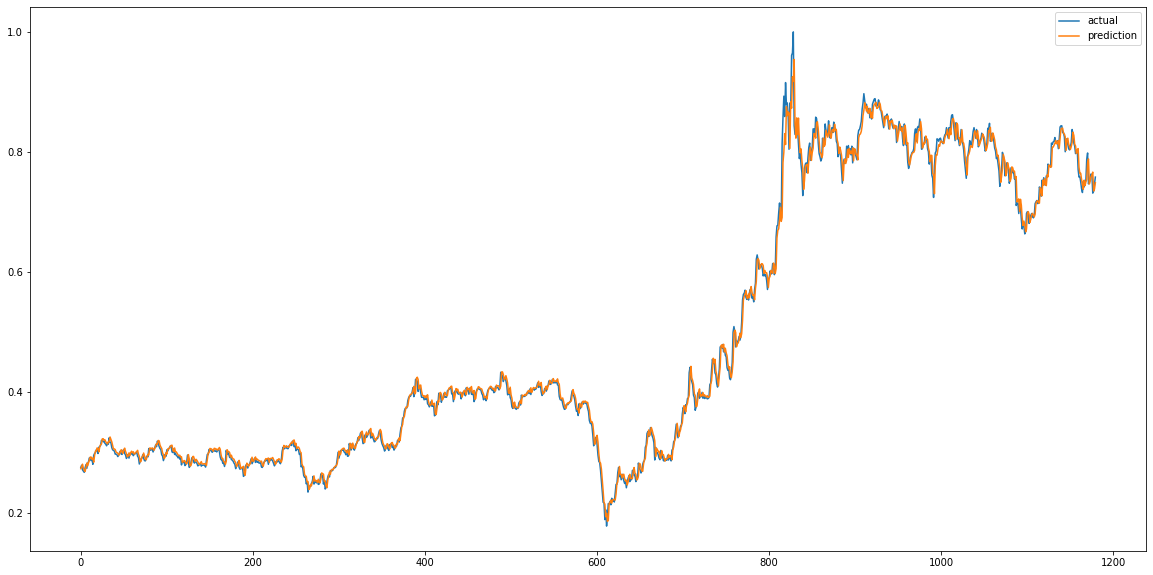

In [36]:
plt.figure(figsize=(20, 10))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()